# Predicting prevalence of hyperglycemia on Zila level

## Introduction

- Data cleaning and preprocessing: DHS and SVRS
- Model fine-tuning using XGBoost
- SVRS: Data preprocessing and preparation
- Predicting and writing output for SVRS data
- Definition of diabetes:
    - Recommendation for diagnosis of diabetes [WHO](https://www.who.int/diabetes/publications/Definition%20and%20diagnosis%20of%20diabetes_new.pdf)
- Hyperglycemia if meets any of the following three criteria:
    - FBG ≥ 126 mg/dl (7.0 mmol/l)
    - Doctor/nurse diagnosed diabetes
    - Taking diabetes medication

## Packages

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import re
import glob
import logging
import itertools
import collections

import numpy as np
import pandas as pd
import seaborn as sns
import pandas_ml as pd_ml
import matplotlib.pyplot as plt

%matplotlib inline
# import matplotlib.pylab as plt
# from matplotlib.pylab import rcParams

import rpy2.robjects as robjects
from rpy2.robjects import packages
from rpy2.robjects import pandas2ri

from scipy import io
from collections import Counter

from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score

from datetime import timedelta
from datetime import datetime as dt

from dbfread import DBF

from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

## Custom functions

In [2]:
def subset_by_var1(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var].notna(),:]
    print(df.shape)
    return df


def subset_by_var2(input_df, var):
    df = input_df.copy(deep=True)
    print(df.shape)
    df = df.loc[df[var] != -9,:]
    print(df.shape)
    return df


def remove_metadata(input_df, metadata):
    df = input_df.copy(deep=True)
    var_select = [var1 for var1,var2 in zip(metadata['variable'],metadata['model_keep']) if var2 == 0]
    print(df.shape)
    df = df.drop(var_select, axis=1)
    print(df.shape)
    return df 
 
def remove_uniform(input_df):
    df = input_df.copy(deep=True)
    var_list = []
    for key, var in enumerate(df):
        tmp = df[var].dropna()
        if len(tmp.unique()) == 1:
            var_list.append(var)
    print(df.shape)
    print(var_list)
    df = df.drop(var_list, axis=1)
    print(df.shape)
    return df
    
def remove_identical(input_df):
    df = input_df.copy(deep=True)
    var_pairs_check = []
    var_pairs = []
    for pair in itertools.combinations(list(df.columns),2):
        var_pairs.append(pair)
        var_pairs_check.append(all(df[pair[0]] == df[pair[1]]))
    selected_pairs = [pair for pair, check in zip(var_pairs, var_pairs_check) if check]
    selected_var = [var2 for var1,var2 in selected_pairs]
    print(df.shape)
    df = df.drop(list(set(selected_var)), axis=1)
    print(df.shape)
    return df


def remove_missing(input_df, threshold):
    df = input_df.copy(deep=True)
    drop_vars = []
    for key, var in enumerate(df):
        null_percent = round(df[var].isnull().mean() * 100,2)
        if null_percent >= threshold:
            drop_vars.append(var)
    print(df.shape)
    df = df.drop(drop_vars, axis=1)
    print(df.shape)
    return df


def check_variables(input_df):
    df = input_df.copy(deep=True)
    var_types = [var_n for var_t,var_n  in zip(df.dtypes, df.columns) if var_t == 'O']
    return var_types

def summarize_variables(input_df, metadata_df):
    metadata = metadata_df.copy(deep=True)
    metadata['num_values'] = 'NaN'
    for key, var in enumerate(metadata.values):
        metadata.loc[key,'num_values'] = len(input_df[var[0]].unique())
    return metadata


def determine_hypertension(input_df):
    df = input_df.copy(deep=True)
    df['hypertension'] = -9
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh250'] == 1. or df.loc[key,'sh249'] == 1. or df.loc[key,'fsysto'] >= 140. or df.loc[key,'fdysto'] >= 90.):
            df.at[key, 'hypertension'] = 1
        elif (df.loc[key,'sh250'] == 0 or df.loc[key,'sh249'] == 0 or df.loc[key,'fsysto'] < 140 or df.loc[key,'fdysto'] < 90):
            df.at[key, 'hypertension'] = 0
        else:
            df.at[key,'hypertension'] = -9
    return df  

def determine_hyperglycaemia(input_df):
    df = input_df.copy(deep=True)
    df['sh280'] = np.where(df['sh280'].isna(), 9999, df['sh280'])
    df['sh280'] = df['sh280'].astype(int).astype(str)
    df['meal'] = 1
    for key,time in enumerate(df['sh280']):
        try:
            df.at[key,'meal'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'meal'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh281'] = np.where(df['sh281'].isna(), 9999, df['sh281'])
    df['sh281'] = df['sh281'].astype(int).astype(str)
    df['drink'] = 1
    for key,time in enumerate(df['sh281']):
        try:
            df.at[key,'drink'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'drink'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    
    df['sh283t'] = np.where(df['sh283t'].isna(), 9999, df['sh283t'])
    df['sh283t'] = df['sh283t'].astype(int).astype(str)
    df['measure_time'] = 1
    for key,time in enumerate(df['sh283t']):
        try:
            df.at[key,'measure_time'] = dt.strptime(time,'%H%M')
        except ValueError:
            df.at[key,'measure_time'] = dt.strptime('2020-01-01:00:00','%Y-%m-%d:%H:%M')
    df['meal'] = pd.to_datetime(df['meal'], format='%Y-%m-%d %H:%M:%S')
    df['drink'] = pd.to_datetime(df['drink'], format='%Y-%m-%d %H:%M:%S')
    df['measure_time'] = pd.to_datetime(df['measure_time'], format='%Y-%m-%d %H:%M:%S')
    df['meal_delta'] = df['meal'] - df['measure_time']
    df['meal_delta'] = df['meal_delta']/np.timedelta64(1,'h')
    df['meal_fasting'] = np.where(df['meal_delta'] > 4, 1, 0)
    df['drink_delta'] = df['drink'] - df['measure_time']
    df['drink_delta'] = df['drink_delta']/np.timedelta64(1,'h')
    df['drink_fasting'] = np.where(df['drink_delta'] > 4, 1, 0)
    df['hyperglycaemia'] = -9
    # sh258: Ever told by a doctor/nurse to have diabetes
    # sh259: Taking medication for the diabetes
    # df.loc[key,'drink_fasting'] == 1. and df.loc[key,'meal_fasting'] == 1. and 
    # df.loc[key,'drink_fasting'] == 0. and df.loc[key,'meal_fasting'] == 0. and 
    for key, value in enumerate(df.values):
        if (df.loc[key,'sh284b'] >= 126 or df.loc[key,'sh258'] == 1 or df.loc[key,'sh259'] == 1):
            df.at[key, 'hyperglycaemia'] = 1
        elif (df.loc[key,'sh284b'] < 126 or df.loc[key,'sh258'] == 0 or df.loc[key,'sh259'] == 0):
            df.at[key, 'hyperglycaemia'] = 0
        else:
            df.at[key, 'hyperglycaemia'] = -9
    return df 


def to_categorical(input_df, input_meta):
    df = input_df.copy(deep=True)
    for var in df.columns:
        if str(input_meta[input_meta['variable'] == var].values[0][4]) == 'categorical':
            df[var] =  df[var].astype('str').astype('category')
    return df

def threshold_cut(input_df, threshold):
    df = input_df.copy(deep=True)
    df = df.sort_values(by='importance', ascending=False)
    df['cumsum'] = np.cumsum(df['importance'])
    df = df[df['cumsum'] >= threshold]
    return df

def get_svrs_metadata(path, pattern):
    out_files = []
    for path, subdirs, files in os.walk(path):
        out_files = out_files + [os.path.join(path,file) for file in files if bool(re.search(pattern=pattern,string=file))]
    return out_files

def search_pattern(input_df, var, pattern):
    df = input_df.copy(deep=True)
    subset = [bool(re.search(pattern=pattern, string=var)) for var in df[var]]
    return df[subset]

def read_dbf(file):
    tmp = DBF(file)
    tmp = pd.DataFrame(iter(tmp))
    return tmp

def read_sav(file):
    foreign = packages.importr('foreign')
    pandas2ri.activate()
    df = foreign.read_spss(file, reencode=False)
    return pd.DataFrame(dict(zip(df.names, map(list,list(df)))))

def read_svrs(file):
    itr = pd.read_stata(file, iterator=True)
    variables = list(itr.variable_labels().values())
    data = pd.read_stata(os.path.join(file))
    original_variables = list(data.columns)
    data.columns = variables
    return data, original_variables

def eer_threshold(model, test_X, test_y):
    predictions = model.predict_proba(test_X)
    predictions = predictions[:,1]
    output = {}
    for i in range(5,100,1):
        y_predicted = np.where(predictions > i/100, 1, 0)
        cm = confusion_matrix(y_pred=y_predicted, y_true=test_y,)
        tn, fp, fn, tp = cm.ravel()
        n = test_y.value_counts()[0]
        p = test_y.value_counts()[1]
        precision = tp/(tp + fp) # positive predictive value
        recall = tp/(tp + fn) # true positive rate
        output[str(i/100)] = precision-recall
    output = pd.DataFrame.from_dict(output,orient='index', columns=['EER'])
    output['EER'] = np.absolute(output['EER'])
    output = output.sort_values(by='EER', ascending=True)
    display(output.head(10))
    return float(output.index[0]), output.iloc[0,0],

def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        xgtest = xgb.DMatrix(dtest[predictors].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Hyperglycaemia'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print(f"Accuracy: {accuracy_score(dtrain['Hyperglycaemia'].values, dtrain_predictions)}")
    print(f"ROC AUC score (Train): {roc_auc_score(dtrain['Hyperglycaemia'], dtrain_predprob)}")

    
    #Predict on testing data:
    # dtest['predprob'] = alg.predict_proba(dtest[predictors])[:,1]
    dtest['predprob'] = alg.predict(dtest[predictors])
    results = X_data_test.merge(dtest[['predprob']])
    print(f"Accuracy (Test): {accuracy_score(results['Hyperglycaemia'], results['predprob'])}")
    print(f"ROC AUC score (Test): {roc_auc_score(results['Hyperglycaemia'], results['predprob'])}")
    print(alg.booster)
    feat_imp = pd.Series(alg._Booster.get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

## Variables

In [3]:
NCD_DATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/data_dd_dhs_ncd.csv'
METADATA = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd.csv'
METADATA_M = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/dhs/ncd_data/metadata_dd_dhs_ncd_m.csv'
SVRS2012 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_12/tafsil-2p.dbf'
SVRS2013 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_13/pop_hh_14-05-2015.sav'
SVRS2014 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_14/tafsil2P_12-06-2015.sav'
SVRS2015 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_15/tafsil-2p.dbf'
SVRS2017 = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/data/bbs/svrs/SVRS_17/tafsl-2p.dta'

## Reading data

In [4]:
ncd_data = pd.read_csv(NCD_DATA)
ncd_metadata = pd.read_csv(METADATA_M)
ncd_metadata.head()

,variable,description,model_keep,num_values,type
0,hhid,Case Identification,0,17141,numeric
1,hvidx,Line number,0,31,categorical
2,hv000,Country code and phase,0,1,categorical
3,hv001,Cluster number,0,600,categorical
4,hv002,Household number,0,184,categorical


In [5]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shsd3,shbm,shri,shcmc,shflg,shsmk,shresi,shed1,shed2,shed3
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
ncd_metadata.columns
ncd_metadata.tail()

,variable,description,model_keep,num_values,type
377,shsmk,NA - Respondent smoking practices,1,1,categorical
378,shresi,Result of individual interview,1,7,categorical
379,shed1,Member's highest educational level,1,5,categorical
380,shed2,Member's highest year of education,1,21,numeric
381,shed3,Highest educational level (CS for preliminary ...,1,7,categorical


In [7]:
# sh258: Ever told by a doctor/nurse to have diabetes
print(ncd_data['sh258'].value_counts())
# sh259: Taking medication for the diabetes
print(ncd_data['sh259'].value_counts())

0.0    6905
1.0     440
9.0       9
Name: sh258, dtype: int64
0.0    7043
1.0     309
9.0       2
Name: sh259, dtype: int64


In [8]:
for var in ncd_metadata['description']:
    if bool(re.search("Sex|sex", var)):
        print(var)
        print(ncd_metadata[ncd_metadata['description'] == var])
        print("#"*100)

Sex of head of household
   variable               description  model_keep  num_values         type
56    hv219  Sex of head of household           1           2  categorical
####################################################################################################
Sex of household member
    variable              description  model_keep  num_values         type
149    hv104  Sex of household member           1           2  categorical
299    sh231  Sex of household member           1           3  categorical
####################################################################################################
Sex
    variable description  model_keep  num_values         type
239     hc27         Sex           1           3  categorical
####################################################################################################
Sex of household member
    variable              description  model_keep  num_values         type
149    hv104  Sex of household member         

## Creating hyperglycaemia target variable

In [9]:
ncd_data = determine_hyperglycaemia(input_df=ncd_data)
print(ncd_data['hyperglycaemia'].value_counts())

-9    74896
 0     6632
 1     2203
Name: hyperglycaemia, dtype: int64


In [10]:
ncd_metadata = summarize_variables(input_df=ncd_data, metadata_df=ncd_metadata)
ncd_metadata.head()
ncd_metadata.to_csv(METADATA_M, index=False, index_label=False)

In [11]:
ncd_data.head()

,Unnamed: 0,hhid,hvidx,hv000,hv001,hv002,hv003,hv004,hv005,hv006,...,shed2,shed3,meal,drink,measure_time,meal_delta,meal_fasting,drink_delta,drink_fasting,hyperglycaemia
0,1,1 3,1,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
1,2,1 3,2,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
2,3,1 3,3,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
3,4,1 3,4,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9
4,5,1 3,5,BD6,1,3,2,1,504672,8,...,NaN,NaN,2020-01-01,2020-01-01,2020-01-01,0.0,0,0.0,0,-9


### Subset data by target variable missingness

In [12]:
data = subset_by_var2(input_df=ncd_data, var='hyperglycaemia')
'hyperglycaemia' in data.columns

(83731, 391)
(8835, 391)


True

### Subset data by metadata file (variables to keep column)

In [13]:
data = remove_metadata(input_df=data, metadata=ncd_metadata)
'hyperglycaemia' in data.columns

(8835, 391)
(8835, 314)


True

### Remove uniformed variables (no variation)

In [14]:
data = remove_uniform(input_df=data)
'hyperglycaemia' in data.columns

(8835, 314)
['hv015', 'hv020', 'hv027', 'hv042', 'hv120', 'hv121', 'hv122', 'hv124', 'sh21', 'ha62', 'hb62']
(8835, 303)


True

### Checking variables

In [15]:
check_variables(input_df=data)

[]

### Removing meta variables

In [16]:
data = data.drop(['Unnamed: 0', 'meal', 'drink', 'measure_time', 'meal_delta', 'meal_fasting', 'drink_delta', 'drink_fasting'],axis=1)
data.head()

,hv009,hv010,hv011,hv012,hv013,hv014,hv016,hv017,hv024,hv025,...,shsd3,shbm,shri,shcmc,shsmk,shresi,shed1,shed2,shed3,hyperglycaemia
12,6,0,0,6,2,1,10,1,1,2,...,9999.0,9999.0,9999.0,917.0,NaN,2.0,1.0,3.0,1.0,1
16,6,0,0,6,2,1,10,1,1,2,...,-88.0,2119.0,1385.0,642.0,NaN,NaN,0.0,NaN,0.0,0
17,6,0,0,6,2,1,10,1,1,2,...,9999.0,9999.0,9999.0,614.0,NaN,NaN,1.0,3.0,1.0,0
26,5,1,1,5,5,1,10,1,1,2,...,-149.0,2068.0,1337.0,907.0,NaN,1.0,1.0,2.0,1.0,0
39,2,0,0,2,2,0,10,1,1,2,...,9999.0,9999.0,9999.0,556.0,NaN,NaN,0.0,NaN,0.0,0


# Predictors
- **Education (completed in years)**
    1. DHS: **hv108** - Education completed in single years
    2. SVRS2017: **q_16** - Level of Education
    - Suggested categories. Read more below.
        - Option 1: SVRS Education breakdown
        - Option 2: Internal Education breakdown
- **Age**
    1. DHS: **hv105** - Age of household members
    2. SVRS2017: **q_10** - Age
- **Urban/rural**
    1. DHS: 'hv025'
    2. SVRS2017: 'Rural/Urban' / 'rmo'
- **Sex**
    1. DHS:'hv104'
    2. SVRS2017: 'Sex'

### DHS Codes	New Codes Categorisation 1
- 0		No education [0]
- 1		Primary Education [1]
- 2		Primary Education [1]
- 3		Primary Education [1]
- 4		Primary Education [1]
- 5		Primary Education [1]
- 6		Secondary Education [2]
- 7		Secondary Education [2]
- 8		Secondary Education [2]
- 9		Secondary Education [2]
- 10	Secondary Education [2]
- 11	Higher Secondary Education [3]
- 12	Higher Secondary Education [3]
- 13	Undergraduate and more [4]
- 14	Undergraduate and more [4]
- 15	Undergraduate and more [4]
- 16	Undergraduate and more [4]
- 17	Undergraduate and more [4]
- 18	Undergraduate and more [4]
- 97	Remove
- 98	Remove

### DHS Codes	New Codes Categorisation 2
- **0** [No education]: 0
- **1,2,3,4** [Primary incomplete]: 1
- **5** [Completed primary]: 2
- **6,7,8,9** [Secondary incomplete]: 3
- **10** [Completed secondary]: 4
- **11-18** [More than secondary]: 5
- **97** [Missing]: Remove
- **98** [Missing]: Remove

In [17]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
orig_data = data[['hv108', 'hv105', 'hv025', 'hv104', 'hyperglycaemia']]
orig_data.columns = variables + ['Hyperglycaemia']
orig_data = orig_data[orig_data['Education'] != 98]
orig_data = orig_data[orig_data['Education'] != 97]
orig_data = orig_data[orig_data['Hyperglycaemia'] != 9]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data = orig_data[orig_data['Education'] != 99]
orig_data.columns

Index(['Education', 'Age', 'Urban/Rural', 'Gender', 'Hyperglycaemia'], dtype='object')

In [18]:
orig_data['Education'].value_counts().sort_index()

0     4084
1      255
2      393
3      324
4      444
5      912
6      166
7      237
8      343
9      471
10     450
11       8
12     307
13       2
14     198
15      58
16     133
17      43
18       6
Name: Education, dtype: int64

In [19]:
edu_categorisation_1 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i >= 11 and i <= 12):
        edu_categorisation_1.append(3)
    elif (i >= 13 and i <= 18):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 4084, 1: 2328, 2: 1667, 4: 440, 3: 315})
0     4084
1      255
2      393
3      324
4      444
5      912
6      166
7      237
8      343
9      471
10     450
11       8
12     307
13       2
14     198
15      58
16     133
17      43
18       6
Name: Education, dtype: int64


In [20]:
edu_categorisation_2 = []
for i in orig_data['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 18):
        edu_categorisation_2.append(5)
    elif (i == 97 or i == 98):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))
print(orig_data['Education'].value_counts().sort_index())

Counter({0: 4084, 1: 1416, 3: 1217, 2: 912, 5: 755, 4: 450})
0     4084
1      255
2      393
3      324
4      444
5      912
6      166
7      237
8      343
9      471
10     450
11       8
12     307
13       2
14     198
15      58
16     133
17      43
18       6
Name: Education, dtype: int64


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Fitting the model using DHS data

In [21]:
orig_data['Education_1'] = edu_categorisation_1 # Our arbitrary categorization
orig_data['Education_1'] = orig_data['Education_1'].astype('category')
orig_data['Education_2'] = edu_categorisation_2 # DHS catgorization of education
orig_data['Education_2'] = orig_data['Education_2'].astype('category')
orig_data['Urban/Rural'] = orig_data['Urban/Rural'].astype('category')
orig_data['Gender'] = orig_data['Gender'].astype('category')
y = orig_data['Hyperglycaemia']
# X = orig_data.drop(['Hyperglycaemia'], axis=1)
# X = orig_data.drop(['Hyperglycaemia', 'Education', 'Education_2'], axis=1)
X = orig_data.drop(['Hyperglycaemia', 'Education', 'Education_1'], axis=1)
X.dtypes
X = pd.get_dummies(X)
X.dtypes

Age              int64
Urban/Rural_1    uint8
Urban/Rural_2    uint8
Gender_1         uint8
Gender_2         uint8
Education_2_0    uint8
Education_2_1    uint8
Education_2_2    uint8
Education_2_3    uint8
Education_2_4    uint8
Education_2_5    uint8
dtype: object

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2, random_state=84)

# Fine-tuning the model - Hyperglycemia

In [23]:
X_data_train = X_train.copy(deep=True)
X_data_train['Hyperglycaemia'] = y_train
X_data_test = X_test.copy(deep=True)
X_data_test['Hyperglycaemia'] = y_test


Model Report
Accuracy: 0.7552002264044149
ROC AUC score (Train): 0.6451189708131669
Accuracy (Test): 0.7606999876588918
ROC AUC score (Test): 0.500114056597062
gbtree


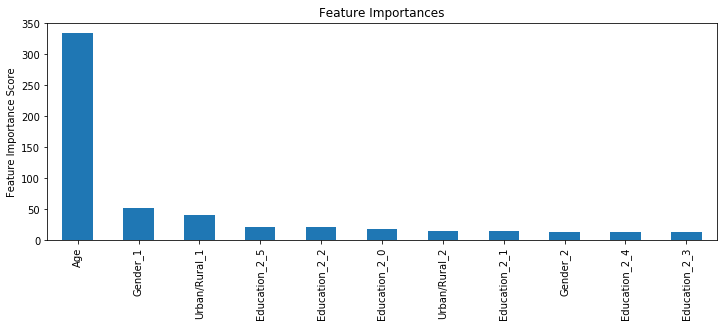

In [24]:
plt.rcParams['figure.figsize'] = 12, 4
target = 'Hyperglycaemia'
predictors = [x for x in X_data_train.columns if x not in [target]]

xgb1 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb1, X_data_train, X_data_test, predictors)

## Grid seach on n_estimators: Initial step

In [34]:
param_test0 = {
    'n_estimators':range(10,1000,200),
}
gsearch0 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(10, 1000, 200)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [35]:
#gsearch0.cv_results_,gsearch0.best_params_, gsearch0.best_score_
print("#"*100)
print(gsearch0.best_params_)
print(gsearch0.best_score_)
print("#"*100)

####################################################################################################
{'n_estimators': 10}
0.599591713453231
####################################################################################################


In [36]:
param_test0a = {
    'n_estimators':range(2,10,2),
}
gsearch0a = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=200, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test0a, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch0a.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'n_estimators': range(2, 10, 2)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [37]:
#gsearch0a.cv_results_,gsearch0a.best_params_, gsearch0a.best_score_
print("#"*100)
print(gsearch0a.best_params_)
print(gsearch0a.best_score_)
print("#"*100)

####################################################################################################
{'n_estimators': 8}
0.5988050917238729
####################################################################################################


## Grid seach on max_depth and min_child_weight: Initial step

In [38]:
param_test1 = {
    'max_depth':range(3,10,1),
    'min_child_weight':range(1,10,1)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': range(3, 10), 'min_child_weight': range(1, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [39]:
#gsearch1.cv_results_,gsearch1.best_params_, gsearch1.best_score_
print("#"*100)
print(gsearch1.best_params_)
print(gsearch1.best_score_)
print("#"*100)

####################################################################################################
{'max_depth': 5, 'min_child_weight': 1}
0.5988050917238729
####################################################################################################


## Grid seach on max_depth and min_child_weight: Step 2

In [40]:
param_test2 = {
    'max_depth':[3,4,5,6,7],
    'min_child_weight':[1,2,3]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=84), 
                       param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'max_depth': [3, 4, 5, 6, 7], 'min_child_weight': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [41]:
#gsearch2.cv_results_,gsearch2.best_params_, gsearch2.best_score_
print(gsearch2.best_params_)
print(gsearch2.best_score_)
print("#"*100)

{'max_depth': 5, 'min_child_weight': 1}
0.5988050917238729
####################################################################################################


## Grid seach on gamma: Initial step

In [42]:
[0,1,5] + [i/10.0 for i in range(0,5)]

[0, 1, 5, 0.0, 0.1, 0.2, 0.3, 0.4]

In [43]:
#Choose all predictors except target & IDcols
param_test3 = {
    'gamma':[0,1,5] + [i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0, 1, 5, 0.0, 0.1, 0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [44]:
# gsearch3.cv_results_,gsearch3.best_params_, gsearch3.best_score_
print("#"*100)
print(gsearch3.best_params_)
print(gsearch3.best_score_)
print("#"*100)


####################################################################################################
{'gamma': 0.4}
0.5993798081728844
####################################################################################################


In [45]:
#Choose all predictors except target & IDcols
param_test4 = {
    'gamma':[0.3,0.4,0.5,0.6,0.7,0.8,0.9]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=8,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=84, silent=True,
       subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'gamma': [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [46]:
# gsearch4.cv_results_,gsearch4.best_params_, gsearch4.best_score_
print("#"*100)
print(gsearch4.best_params_)
print(gsearch4.best_score_)
print("#"*100)

####################################################################################################
{'gamma': 0.4}
0.5993798081728844
####################################################################################################


# Evaluate importance and accuracy


Model Report
Accuracy: 0.7537851988113768
ROC AUC score (Train): 0.6298089774608185
Accuracy (Test): 0.7598244186456896
ROC AUC score (Test): 0.5000882846972697
gbtree


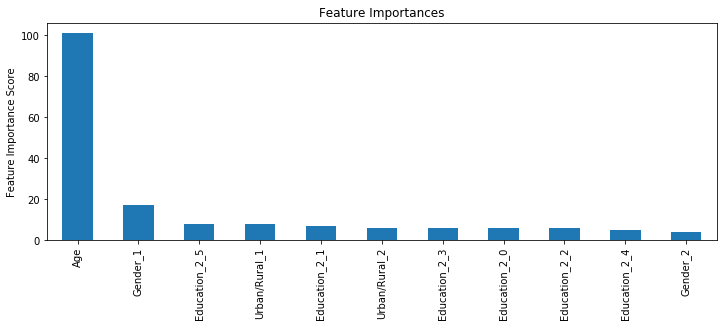

In [47]:
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb2 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=8,
        max_depth=5,
        min_child_weight=1,
        gamma=0.4,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb2, X_data_train, X_data_test, predictors)

## Grid seach on subsample and colsample_bytree: Initial step

In [48]:
#Choose all predictors except target & IDcols
param_test5 = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0.4, subsample=0.8, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.8),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [49]:
print(gsearch5.best_params_)
print(gsearch5.best_score_)
print("#"*100)
#gsearch5.cv_results_,gsearch5.best_params_, gsearch5.best_score_

{'colsample_bytree': 0.8, 'subsample': 0.7}
0.5994331360079108
####################################################################################################


## Grid seach on subsample and colsample_bytree:  Fine-tune

In [50]:
[i/100.0 for i in range(60,80,3)]

[0.6, 0.63, 0.66, 0.69, 0.72, 0.75, 0.78]

In [51]:
#Choose all predictors except target & IDcols
param_test6 = {
    'subsample':[i/100.0 for i in range(60,80,3)],
    'colsample_bytree':[i/100.0 for i in range(70,100,3)]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0.4, subsample=0.7, colsample_bytree=0.8,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.7),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'subsample': [0.6, 0.63, 0.66, 0.69, 0.72, 0.75, 0.78], 'colsample_bytree': [0.7, 0.73, 0.76, 0.79, 0.82, 0.85, 0.88, 0.91, 0.94, 0.97]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [52]:
print(gsearch6.best_params_)
print(gsearch6.best_score_)
print("#"*100)
#gsearch6.cv_results_,gsearch6.best_params_, gsearch6.best_score_

{'colsample_bytree': 0.7, 'subsample': 0.69}
0.5991582271269839
####################################################################################################


## Grid seach on reg_alpha: Initial step

In [53]:
#Choose all predictors except target & IDcols
param_test7 = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0.4, subsample=0.69, colsample_bytree=0.7,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test7, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch7.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.69),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [54]:
#gsearch7.cv_results_,gsearch7.best_params_, gsearch7.best_score_
print("#"*100)
print(gsearch7.best_params_)
print(gsearch7.best_score_)
print("#"*100)

####################################################################################################
{'reg_alpha': 1e-05}
0.5991582271269839
####################################################################################################


## Grid seach on reg_alpha: Fine-tune

In [55]:
#Choose all predictors except target & IDcols
param_test8 = {
    'reg_alpha':[1e-07 ,5e-07  ,1e-06  ,5e-06 , 1e-05, 5e-05, 1e-04, 5e-04, 1e-03]
}
gsearch8 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0.4, subsample=0.69, colsample_bytree=0.7,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test8, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch8.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.69),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'reg_alpha': [1e-07, 5e-07, 1e-06, 5e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [56]:
# gsearch8.cv_results_,gsearch8.best_params_, gsearch8.best_score_
print("#"*100)
print(gsearch8.best_params_)
print(gsearch8.best_score_)
print("#"*100)

####################################################################################################
{'reg_alpha': 0.0005}
0.5991769251225304
####################################################################################################


In [57]:
## Grid seach on learning_rate: Fine-tune

In [58]:
#Choose all predictors except target & IDcols
param_test9 = {
    'learning_rate':[0.01, 0.025, 0.05, 0.075, 0.1]
}
gsearch9 = GridSearchCV(estimator = XGBClassifier(learning_rate=0.1, n_estimators=8, max_depth=5,
                                        min_child_weight=1, gamma=0.4, subsample=0.69, colsample_bytree=0.7,
                                        objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=84), 
                       param_grid = param_test9, scoring='roc_auc',n_jobs=4,iid=False, cv=10)
gsearch9.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.7, gamma=0.4, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=1, missing=None,
       n_estimators=8, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=84, silent=True, subsample=0.69),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [59]:
print(gsearch9.best_params_)
print(gsearch9.best_score_)
print("#"*100)
# gsearch9.cv_results_,gsearch9.best_params_, gsearch9.best_score_

{'learning_rate': 0.1}
0.5991582271269839
####################################################################################################



Model Report
Accuracy: 0.753643696052073
ROC AUC score (Train): 0.6233000936549965
Accuracy (Test): 0.7595390732088014
ROC AUC score (Test): 0.5000450396513266
gbtree


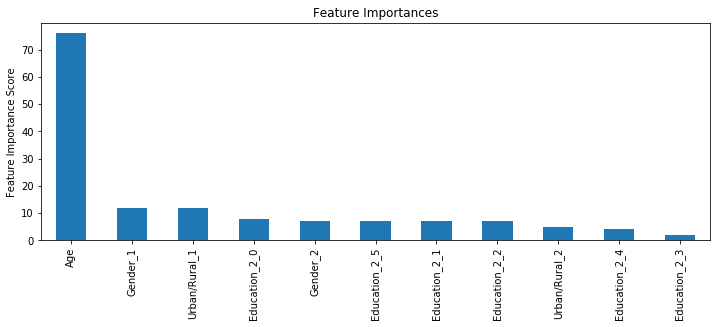

In [25]:
plt.rcParams['figure.figsize'] = 12, 4
target = 'Hyperglycaemia'
predictors = [x for x in X_data_train.columns if x not in [target]]
xgb3 = XGBClassifier(
        learning_rate =0.1,
        n_estimators=8,
        max_depth=5,
        min_child_weight=1,
        gamma=0.4,
        subsample=0.69,
        colsample_bytree=0.7,
        reg_alpha=0.0005,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=84)
modelfit(xgb3, X_data_train, X_data_test, predictors)

In [26]:
eer_threshold(xgb3, test_X=X_test, test_y=y_test)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:197: RuntimeWarning: invalid value encountered in long_scalars


,EER
0.38,0.015920
0.37,0.055451
0.39,0.112330
0.4,0.177337
0.36,0.184520
0.41,0.230455
0.42,0.320496
0.43,0.338839
0.46,0.352861
0.45,0.353271


(0.38, 0.015919919369617008)

0.04212490180675571


0.06400409626216078

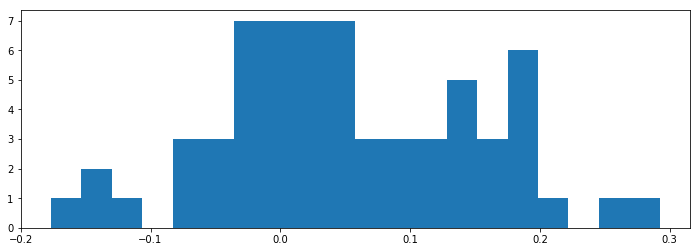

In [27]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.38, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'shdistrict']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].median()

0.04498816101026046


0.045411861862387805

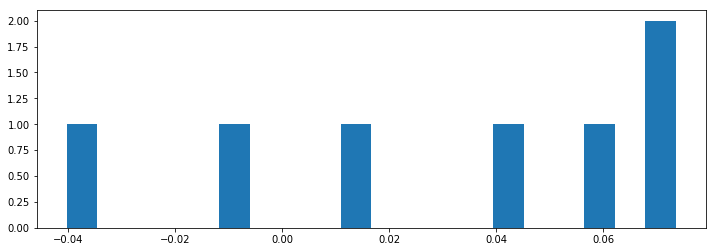

In [28]:
y_predicted = xgb3.predict_proba(X)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.38, 1, 0)
eval_prevalence = pd.DataFrame.from_dict({'actual': y, 'predicted': y_predicted, 'district':ncd_data.loc[y.index,'hv024']})
eval_prevalence = eval_prevalence.groupby('district').sum()/eval_prevalence.groupby('district').count()
plt.hist(eval_prevalence['actual'] - eval_prevalence['predicted'], bins=20)
print((eval_prevalence['actual'] - eval_prevalence['predicted']).median())
eval_prevalence['difference'] = np.absolute(eval_prevalence['actual'] - eval_prevalence['predicted'])
eval_prevalence['difference'].mean()

In [29]:
y_predicted = xgb3.predict_proba(X_test)
y_predicted = y_predicted[:,1]
y_predicted = np.where(y_predicted > 0.38, 1, 0)
cm1= pd_ml.ConfusionMatrix(y_pred=y_predicted, y_true=y_test,)
cm2 = confusion_matrix(y_pred=y_predicted, y_true=y_test,)
print(cm1)

Predicted  False  True  __all__
Actual                         
False         21     9       30
True           5     3        8
__all__       26    12       38


In [30]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.79      0.80      0.79      1339
           1       0.34      0.32      0.33       428

   micro avg       0.68      0.68      0.68      1767
   macro avg       0.56      0.56      0.56      1767
weighted avg       0.68      0.68      0.68      1767



#################################################################################################################
#################################################################################################################
#################################################################################################################

# Predicting hyperglycemia prevalence using SVRS 2013, 2014 and 2017 data

- SVRS 2012: DBF
- SVRS 2013: SAV
- SVRS 2014: SAV
- SVRS 2015: DBF
- SVRS 2017: DTA

### SVRS Codes	New Codes Categorisation 1
- **Did not passed 1st grade** 0 [No education]: 0	
- **Passed 1st grade**	1	[Primary Education]: 1
- **Passed 2nd grade**	2	[Primary Education]: 1
- **Passed 3rd grade**	3	[Primary Education]: 1
- **Passed 4th grade**	4	[Primary Education]: 1
- **Passed 5th grade**	5	[Primary Education]: 1
- **Passed 6th grade**	6	[Secondary Education]: 2
- **Passed 7th grade**	7	[Secondary Education]: 2
- **Passed 8th grade**	8	[Secondary Education]: 2
- **Passed 9th grade**	9	[Secondary Education]: 2
- **Secondery or equal**	10	[Secondary Education]: 2
- **Higher secondary or equal**	11	[Higher Secondary Education]: 3
- **Undergraduate or equal**	12	[Undergraduate and more]: 4
- **Graduate or equal**	13	[Undergraduate and more]: 4
- **Doctor/Engineer/Agriculturist**	14	[Undergraduate and more]: 4
- **Diploma**	15	[Undergraduate and more]: 4
- **Vocational**	16	[Higher Secondary Education]: 3
- **Others**	17	[Remove]: -1

### SVRS Codes	New Codes Categorisation 2
- **Did not passed 1st grade**	0	[No education]: 0
- **Passed 1st grade**	1	[Primary incomplete]: 1
- **Passed 2nd grade**	2	[Primary incomplete]: 1
- **Passed 3rd grade**	3	[Primary incomplete]: 1
- **Passed 4th grade**	4	[Primary incomplete]: 1
- **Passed 5th grade**	5	[Completed primary]: 2
- **Passed 6th grade**	6	[Secondary incomplete]: 3
- **Passed 7th grade**	7	[Secondary incomplete]: 3
- **Passed 8th grade**	8	[Secondary incomplete]: 3
- **Passed 9th grade**	9	[Secondary incomplete]: 3
- **Secondery or equal**	10	[Completed secondary]: 4
- **Higher secondary or equal**	11	[More than secondary]: 5
- **Undergraduate or equal**	12	[More than secondary]: 5
- **Graduate or equal**	13	[More than secondary]: 5
- **Doctor/Engineer/Agriculturist**	14	[More than secondary]: 5
- **Diploma**	15	[More than secondary]: 5
- **Vocational**	16	[More than secondary]: 5
- **Others**	17	[Remove]: -1

## SVRS2012

In [66]:
data_svrs2012r = read_dbf(SVRS2012)
data_svrs2012r = data_svrs2012r[data_svrs2012r['Q_16'] != 99]
data_svrs2012r['RMO'] = np.where(data_svrs2012r['RMO'] != '1', 2, 1) # Urban=1, Rural=2
data_svrs2012r['RMO'] = data_svrs2012r['RMO'].astype(int).astype('category')
data_svrs2012r['Q_12'] = data_svrs2012r['Q_12'].astype(int).astype('category') # Male=1, Female=2
data_svrs2012r = data_svrs2012r[data_svrs2012r['Q_11'] >= 35]

In [67]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2012 = data_svrs2012r[['Q_16', 'Q_11', 'RMO', 'Q_12']]
data_svrs2012.columns = variables

In [68]:
print(data_svrs2012r.shape)
print(data_svrs2012.shape)

(366585, 27)
(366585, 4)


In [69]:
print(data_svrs2012['Education'].value_counts().sort_index())

0     176475
1       3913
2      12493
3      10979
4      11243
5      46627
6       8215
7       7746
8      17188
9      16985
10     23032
11     11686
12     12949
13      5034
14      1261
15       389
16       370
Name: Education, dtype: int64


In [70]:
edu_categorisation_1 = []
for i in data_svrs2012['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))

Counter({0: 176475, 1: 85255, 2: 73166, 4: 19633, 3: 12056})


In [71]:
edu_categorisation_2 = []
for i in data_svrs2012['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))
print(data_svrs2012['Education'].value_counts().sort_index())

Counter({0: 176475, 3: 50134, 2: 46627, 1: 38628, 5: 31689, 4: 23032})
0     176475
1       3913
2      12493
3      10979
4      11243
5      46627
6       8215
7       7746
8      17188
9      16985
10     23032
11     11686
12     12949
13      5034
14      1261
15       389
16       370
Name: Education, dtype: int64


In [72]:
# data_svrs2012['Education_1'] = edu_categorisation_1
# data_svrs2012['Education_1'] = data_svrs2012['Education_1'].astype('category')
data_svrs2012['Education_2'] = edu_categorisation_2
data_svrs2012['Education_2'] = data_svrs2012['Education_2'].astype('category')
data_svrs2012 = data_svrs2012.drop(['Education'], axis =1)
data_svrs2012 = pd.get_dummies(data_svrs2012)
data_svrs2012.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,60,1,0,1,0,0,0,0,0,1,0
1,41,1,0,0,1,0,0,0,1,0,0
4,48,1,0,1,0,0,0,1,0,0,0
5,41,1,0,0,1,0,0,0,1,0,0
9,61,1,0,0,1,0,1,0,0,0,0


## SVRS2013

In [73]:
data_svrs2013r = read_sav(SVRS2013)
print(data_svrs2013r.shape)
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q16'].notna()]
print(data_svrs2013r.shape)
print("\n")
print("#"*100)
print(data_svrs2013r['RMO'].value_counts().sort_index())
print(data_svrs2013r['Q12'].value_counts().sort_index())
print("#"*100)
print("\n")
data_svrs2013r['Q16'] = data_svrs2013r['Q16'].astype('category')
print(data_svrs2013r['Q16'].value_counts())
data_svrs2013r['Q16'] = data_svrs2013r['Q16'].cat.rename_categories({'None':0, 'Class I passed':1, 'Class II passed':2,
 'Class III passed':3, 'Class IV passed':4, 'Class V passed':5,
 'Class VI passed':6, 'Class VII passed':7, 'Class VIII passed':8,
 'Class IXpassed':9, 'SSC or equvalent': 10, 'HSC or equvalent':11,
 'Degree or equvalent':12, 'Masters or equvalent':13, 'Doctor.Engineer/Krishibid':14,
 'Diploma':15, 'Vocational':16, 'Other':99})
data_svrs2013r['Q16'] = data_svrs2013r['Q16'].astype(int)
print(data_svrs2013r['Q16'].value_counts())
print(data_svrs2013r.shape)
print("#"*100)
print("\n")
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q11'] >= 35]
print(data_svrs2013r.shape)
print("#"*100)
print("\n")
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q16'] != 99]
data_svrs2013r = data_svrs2013r[data_svrs2013r['Q11'] != 99.0]
data_svrs2013r['RMO'] = np.where(data_svrs2013r['RMO'] != 'Rural', 2, 1)
data_svrs2013r['RMO'] = data_svrs2013r['RMO'].astype(int).astype('category')
data_svrs2013r['Q12'] = np.where(data_svrs2013r['Q12'] != 'Male', 1, 2)
data_svrs2013r['Q12'] = data_svrs2013r['Q12'].astype(int).astype('category')
print(data_svrs2013r.shape)

(692763, 44)
(613023, 44)


####################################################################################################
City corporation    124910
Municipality        102166
Rural               338314
Upazila HQ           47633
Name: RMO, dtype: int64
Female    302821
Male      310202
Name: Q12, dtype: int64
####################################################################################################


None                         151660
Class V passed                79700
SSC or equvalent              49139
Class VIII passed             39721
Class IXpassed                37609
Class II passed               37346
Class IV passed               34849
Class III passed              33904
HSC or equvalent              30952
Class I passed                28689
Class VII passed              26147
Class VI passed               25854
Degree or equvalent           21060
Masters or equvalent          10540
Doctor.Engineer/Krishibid      2791
Diploma                        1329
Ot

In [74]:
data_svrs2013 = data_svrs2013r[['Q16', 'Q11', 'RMO', 'Q12']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2013.columns = variables

In [75]:
print(data_svrs2013r.shape)
print(data_svrs2013.shape)

(223039, 44)
(223039, 4)


In [76]:
edu_categorisation_1 = []
for i in data_svrs2013['Education'].astype(int):
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1 or i == 99):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(len(edu_categorisation_1))


Counter({0: 94689, 1: 55757, 2: 47107, 4: 16571, 3: 8915})
223039


In [77]:
edu_categorisation_2 = []
for i in data_svrs2013['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))


Counter({0: 94689, 3: 31187, 2: 28805, 1: 26952, 5: 25486, 4: 15920})


In [78]:
print(data_svrs2013.shape)
print(len(edu_categorisation_2))

(223039, 4)
223039


In [79]:
# data_svrs2013['Education_1'] = edu_categorisation_1
# data_svrs2013['Education_1'] = data_svrs2013['Education_1'].astype('category')
data_svrs2013['Education_2'] = edu_categorisation_2
data_svrs2013['Education_2'] = data_svrs2013['Education_2'].astype('category')
data_svrs2013 = data_svrs2013.drop(['Education'], axis =1)
data_svrs2013 = pd.get_dummies(data_svrs2013)
data_svrs2013.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,51.0,0,1,0,1,0,0,0,0,0,1
1,41.0,0,1,1,0,0,0,0,1,0,0
7,49.0,0,1,0,1,0,0,0,1,0,0
8,41.0,0,1,1,0,0,1,0,0,0,0
10,37.0,0,1,0,1,0,0,0,1,0,0


## SVRS2014

In [80]:
data_svrs2014r = read_sav(SVRS2014)
print(data_svrs2014r.shape)
print("#"*100)
print("\n")
print(data_svrs2014r['Q16'].value_counts().sort_index())
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q11'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q12'].notna()]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 'Other']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '4.05']
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != '99']
data_svrs2014r['Q16'] = data_svrs2014r['Q16'].astype(int)
print(data_svrs2014r['Q16'].value_counts().sort_index())
data_svrs2014r['Q11'] = data_svrs2014r['Q11'].astype(int)
data_svrs2014r['RMO'] = np.where(data_svrs2014r['RMO'] != 'Rural', 2, 1)
print(data_svrs2014r['RMO'].value_counts())
data_svrs2014r['RMO'] = data_svrs2014r['RMO'].astype(int).astype('category')
data_svrs2014r['Q12'] = np.where(data_svrs2014r['Q12'] == 'Male', 1, 2)
data_svrs2014r['Q12'] = data_svrs2014r['Q12'].astype(int).astype('category')
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 99]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q16'] != 99]
data_svrs2014r = data_svrs2014r[data_svrs2014r['Q11'] >= 35]
print("#"*100)
print("\n")
print(data_svrs2014r.shape)

(692412, 25)
####################################################################################################


0        150471
1         23693
10        48156
11        33006
12        22023
13        11149
14         2658
15         1207
16          482
2         36364
3         35800
4         37592
4.05          1
5         79398
6         26203
7         27433
8         40099
9         41349
Other       547
Name: Q16, dtype: int64
0     150471
1      23693
2      36364
3      35800
4      37592
5      79398
6      26203
7      27433
8      40099
9      41349
10     48156
11     33006
12     22023
13     11149
14      2658
15      1207
16       482
Name: Q16, dtype: int64
1    340701
2    276382
Name: RMO, dtype: int64
####################################################################################################


(233634, 25)


In [81]:
data_svrs2014 = data_svrs2014r[['Q16', 'Q11', 'RMO', 'Q12']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2014.columns = variables

In [82]:
print(data_svrs2014.shape)
print(data_svrs2014r.shape)
print(data_svrs2014['Education'].value_counts().sort_index())

(233634, 4)
(233634, 25)
0     97045
1      3561
2      8375
3      7117
4      7744
5     29584
6      4291
7      4983
8     12447
9     10928
10    16739
11    10882
12    11282
13     6400
14     1434
15      588
16      234
Name: Education, dtype: int64


In [83]:
edu_categorisation_1 = []
for i in data_svrs2014['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))
print(len(edu_categorisation_1))

Counter({0: 97045, 1: 56381, 2: 49388, 4: 19704, 3: 11116})
233634


In [84]:
edu_categorisation_2 = []
print()
for i in data_svrs2014['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99 or i == 98):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))
print(len(edu_categorisation_2))


Counter({0: 97045, 3: 32649, 5: 30820, 2: 29584, 1: 26797, 4: 16739})
233634


In [85]:
# data_svrs2014['Education_1'] = edu_categorisation_1
# data_svrs2014['Education_1'] = data_svrs2014['Education_1'].astype('category')
data_svrs2014['Education_2'] = edu_categorisation_2
data_svrs2014['Education_2'] = data_svrs2014['Education_2'].astype('category')
data_svrs2014 = data_svrs2014.drop(['Education'], axis =1)
data_svrs2014 = pd.get_dummies(data_svrs2014)
data_svrs2014.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,52,0,1,1,0,0,0,0,0,0,1
1,42,0,1,0,1,0,0,0,1,0,0
5,57,0,1,0,1,0,0,0,0,1,0
7,50,0,1,1,0,0,0,0,1,0,0
8,42,0,1,0,1,0,1,0,0,0,0


## SVRS2015

In [86]:
data_svrs2015r = read_dbf(SVRS2015)
print("#"*100)
print("\n")
print(data_svrs2015r['RMO'].value_counts())
data_svrs2015r['RMO'] = np.where(data_svrs2015r['RMO'] != '1', 2, 1)
print(data_svrs2015r['Q_16'].value_counts().sort_index())
data_svrs2015r['RMO'] = data_svrs2015r['RMO'].astype(int).astype('category')
data_svrs2015r['Q_11'] = data_svrs2015r['Q_11'].astype(int).astype('category')
data_svrs2015r = data_svrs2015r[data_svrs2015r['Q_16'] != 99]
data_svrs2015r = data_svrs2015r[data_svrs2015r['Q_10'] >= 35]
print(data_svrs2015r['Q_16'].value_counts())
print("#"*100)
print("\n")


####################################################################################################


1    566771
2    215526
3    136780
4     20453
Name: RMO, dtype: int64
0     298714
1      30575
2      48923
3      45678
4      49577
5     107993
6      37407
7      38352
8      56663
9      57350
10     67358
11     47072
12     30443
13     16245
14      3489
15      1841
16       738
99      1112
Name: Q_16, dtype: int64
0     130262
5      40892
10     23044
8      17583
9      15450
11     13280
12     13093
2      12803
4      10959
3       9899
13      8792
7       7264
6       6231
1       5073
14      1750
15       791
16       334
Name: Q_16, dtype: int64
####################################################################################################




In [87]:
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2015 = data_svrs2015r[['Q_16', 'Q_10', 'RMO', 'Q_11']]
data_svrs2015.columns = variables

In [88]:
print(data_svrs2015r.shape)
print(data_svrs2015.shape)

(317500, 21)
(317500, 4)


In [89]:
print(data_svrs2015['Education'].value_counts().sort_index())

0     130262
1       5073
2      12803
3       9899
4      10959
5      40892
6       6231
7       7264
8      17583
9      15450
10     23044
11     13280
12     13093
13      8792
14      1750
15       791
16       334
Name: Education, dtype: int64


In [90]:
edu_categorisation_1 = []
for i in data_svrs2015['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))

Counter({0: 130262, 1: 79626, 2: 69572, 4: 24426, 3: 13614})


In [91]:
edu_categorisation_2 = []
for i in data_svrs2015['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99 or i == 98):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))

Counter({0: 130262, 3: 46528, 2: 40892, 1: 38734, 5: 38040, 4: 23044})


In [92]:
# data_svrs2015['Education_1'] = edu_categorisation_1
# data_svrs2015['Education_1'] = data_svrs2015['Education_1'].astype('category')
data_svrs2015['Education_2'] = edu_categorisation_2
data_svrs2015['Education_2'] = data_svrs2015['Education_2'].astype('category')
data_svrs2015 = pd.get_dummies(data_svrs2015)
data_svrs2015 = data_svrs2015.drop(['Education'], axis =1)
data_svrs2015.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
0,53,0,1,1,0,0,0,0,0,0,1
1,43,0,1,0,1,0,0,0,1,0,0
4,46,0,1,1,0,0,0,0,1,0,0
5,38,0,1,0,1,0,1,0,0,0,0
8,39,0,1,1,0,0,0,0,1,0,0


## SVRS2017

In [31]:
data_svrs2017r, original_variables = read_svrs(SVRS2017)
print(data_svrs2017r.shape)
print("#"*100)
print("\n")
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 9]
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Rural Urban code'] != 3]
data_svrs2017r['  Level of Education'] = data_svrs2017r['  Level of Education'].astype(int)
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Level of Education'] != 99]
data_svrs2017r['  Rural Urban code'] = data_svrs2017r['  Rural Urban code'].astype(int).astype('category')
print(data_svrs2017r['  Rural Urban code'].value_counts())
print(data_svrs2017r['  Sex'].value_counts())
data_svrs2017r['  Sex'] = data_svrs2017r['  Sex'].astype(int).astype('category')
data_svrs2017r = data_svrs2017r[data_svrs2017r['  Age'] >= 35]
print(data_svrs2017r.shape)
print("#"*100)
print("\n")

(1252581, 30)
####################################################################################################


1    699584
2    210929
Name:   Rural Urban code, dtype: int64
1.0    455602
2.0    454911
Name:   Sex, dtype: int64
(319358, 30)
####################################################################################################




In [32]:
data_svrs2017 = data_svrs2017r[['  Level of Education', '  Age', '  Rural Urban code','  Sex']]
variables = ['Education', 'Age', 'Urban/Rural', 'Gender']
data_svrs2017.columns = variables

In [33]:
edu_categorisation_1 = []
for i in data_svrs2017['Education']:
    if i == 0:
        edu_categorisation_1.append(0)
    elif (i >= 1 and i <= 5):
        edu_categorisation_1.append(1)
    elif (i >= 6 and i <= 10):
        edu_categorisation_1.append(2)
    elif (i == 11 or i == 16):
        edu_categorisation_1.append(3)
    elif (i >= 12 and i <= 15):
        edu_categorisation_1.append(4)
    elif (i == 97 or i == 98 or i == 17 or i == -1):
        edu_categorisation_1.append(-1)
print(Counter(edu_categorisation_1))

Counter({0: 138216, 1: 88873, 2: 66739, 4: 15720, 3: 9810})


In [34]:
edu_categorisation_2 = []
for i in data_svrs2017['Education']:
    if i == 0:
        edu_categorisation_2.append(0)
    elif (i >= 1 and i <= 4):
        edu_categorisation_2.append(1)
    elif (i == 5):
        edu_categorisation_2.append(2)
    elif (i >= 6 and i <= 9):
        edu_categorisation_2.append(3)
    elif (i == 10):
        edu_categorisation_2.append(4)
    elif (i >= 11 and i <= 16):
        edu_categorisation_2.append(5)
    elif (i == 17 or i == -1 or i == 99):
        edu_categorisation_2.append(-1)
print(Counter(edu_categorisation_2))


Counter({0: 138216, 3: 47269, 2: 44724, 1: 44149, 5: 25530, 4: 19470})


In [35]:
# data_svrs2017['Education_1'] = edu_categorisation_1
# data_svrs2017['Education_1'] = data_svrs2017['Education_1'].astype('category')
data_svrs2017['Education_2'] = edu_categorisation_2
data_svrs2017['Education_2'] = data_svrs2017['Education_2'].astype('category')
print(data_svrs2017['Education_2'].value_counts())
data_svrs2017 = pd.get_dummies(data_svrs2017)
data_svrs2017 = data_svrs2017.drop(['Education',], axis=1)
print(data_svrs2017.shape)
data_svrs2017.head()

0    138216
3     47269
2     44724
1     44149
5     25530
4     19470
Name: Education_2, dtype: int64
(319358, 11)


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,Age,Urban/Rural_1,Urban/Rural_2,Gender_1,Gender_2,Education_2_0,Education_2_1,Education_2_2,Education_2_3,Education_2_4,Education_2_5
2,55.0,0,1,0,1,0,0,0,0,0,1
3,45.0,0,1,0,1,0,0,0,1,0,0
4,53.0,0,1,1,0,0,0,0,1,0,0
5,45.0,0,1,0,1,0,1,0,0,0,0
10,36.0,0,1,1,0,0,0,0,0,1,0


In [39]:
print(data_svrs2012r['Q_11'].value_counts().sort_index()[18:].sum()/data_svrs2012r['Q_11'].value_counts().sort_index().sum())
print(data_svrs2014r['Q11'].value_counts().sort_index()[18:].sum()/data_svrs2014r['Q11'].value_counts().sort_index().sum())
print(data_svrs2015r['Q_10'].value_counts().sort_index()[18:].sum()/data_svrs2015r['Q_10'].value_counts().sort_index().sum())
print(data_svrs2017r['  Age'].value_counts().sort_index()[18:].sum()/data_svrs2017r['  Age'].value_counts().sort_index().sum())

1.0


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Prediting hyperglycemia and writing results out

In [41]:
# data_svrs2012r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2012)[:,1]
# data_svrs2012r['Hyperglycaemia'] = np.where(data_svrs2012r['Hyperglycaemia'] > 0.38, 1, 0)
# data_svrs2013r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2013)[:,1]
# data_svrs2013r['Hyperglycaemia'] = np.where(data_svrs2013r['Hyperglycaemia'] > 0.38, 1, 0)
# data_svrs2014r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2014)[:,1]
# data_svrs2014r['Hyperglycaemia'] = np.where(data_svrs2014r['Hyperglycaemia'] > 0.38, 1, 0)
# data_svrs2015r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2015)[:,1]
# data_svrs2015r['Hyperglycaemia'] = np.where(data_svrs2015r['Hyperglycaemia'] > 0.38, 1, 0)
data_svrs2017r['Hyperglycaemia'] = xgb3.predict_proba(data_svrs2017)[:,1]
data_svrs2017r['Hyperglycaemia'] = np.where(data_svrs2017r['Hyperglycaemia'] > 0.38, 1, 0)

In [42]:
# print(f"Predictions for 2012:\n {data_svrs2012r['Hyperglycaemia'].value_counts()/data_svrs2012r.shape[0]*100}")
# print(f"Predictions for 2013:\n {data_svrs2013r['Hyperglycaemia'].value_counts()/data_svrs2013r.shape[0]*100}")
# print(f"Predictions for 2014:\n {data_svrs2014r['Hyperglycaemia'].value_counts()/data_svrs2014r.shape[0]*100}")
# print(f"Predictions for 2015:\n {data_svrs2015r['Hyperglycaemia'].value_counts()/data_svrs2015r.shape[0]*100}")
print(f"Predictions for 2017:\n {data_svrs2017r['Hyperglycaemia'].value_counts()/data_svrs2017r.shape[0]*100}")

Predictions for 2017:
 0    67.334465
1    32.665535
Name: Hyperglycaemia, dtype: float64


#################################################################################################################
#################################################################################################################
#################################################################################################################

# Writing results out

In [101]:
OUT = '/Users/edinhamzic/Symphony/wb_bangladesh/Bangladesh/output/ncd/'

## Writing out 2012

In [102]:
data_svrs2012r["DIVN_ZILA"] = data_svrs2012r["DIVN"].str.cat(data_svrs2012r["ZILA"])
tmp1 = data_svrs2012r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2012r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2012_2.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,1004,1711,4917,34.80
1,1006,2224,6499,34.22
2,1009,1416,4942,28.65
3,1042,1722,4532,38.00
4,1078,1897,5399,35.14


## Writing out 2013

In [103]:
tmp1 = data_svrs2013r[["zila", "Hyperglycaemia"]].groupby('zila').sum().reset_index()
tmp1.columns = ["zila", "Hyperglycaemia count"]
tmp2 = data_svrs2013r[["zila", "Hyperglycaemia"]].groupby('zila').count().reset_index()
tmp2.columns = ["zila", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='zila')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2013_2.csv', index=False, index_label=False)
tmp.head()

,zila,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,Bagerhat,912,2328,39.18
1,Bandarban,88,556,15.83
2,Barguna,697,1851,37.66
3,Barisal,3705,11728,31.59
4,Bhola,868,3605,24.08


## Writing out 2014

In [104]:
data_svrs2014r["DIVN_ZILA"] = data_svrs2014r["zila"]
tmp1 = data_svrs2014r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2014r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2014_2.csv', index=False, index_label=False)
tmp.head()## Writing out 2012


,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,Bagerhat,928,2367,39.21
1,Bandarban,123,634,19.40
2,Barguna,771,1944,39.66
3,Barisal,4159,11850,35.10
4,Bhola,861,3412,25.23


## Writing out 2015

In [105]:
data_svrs2015r["DIVN_ZILA"] = data_svrs2015r["ZILA"]
tmp1 = data_svrs2015r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2015r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2015_2.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,01,1563,3602,43.39
1,03,244,1149,21.24
2,04,1228,2973,41.31
3,06,5371,16144,33.27
4,09,1783,4997,35.68


## Writing out 2017

In [106]:
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["Zila code"].astype(int).astype(str)
data_svrs2017r["DIVN_ZILA"] = data_svrs2017r["DIVN_ZILA"].str.pad(width=2, side='left', fillchar='0')
tmp1 = data_svrs2017r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').sum().reset_index()
tmp1.columns = ["DIVN_ZILA", "Hyperglycaemia count"]
tmp2 = data_svrs2017r[["DIVN_ZILA", "Hyperglycaemia"]].groupby('DIVN_ZILA').count().reset_index()
tmp2.columns = ["DIVN_ZILA", "Total count"]
tmp = tmp1.merge(tmp2, how='left', on='DIVN_ZILA')
tmp['Hyperglycaemia prevalence'] = np.round(tmp['Hyperglycaemia count']/tmp['Total count']*100,2)
tmp.to_csv(OUT +'/hyperglycemia_prevalence_2017_2.csv', index=False, index_label=False)
tmp.head()

,DIVN_ZILA,Hyperglycaemia count,Total count,Hyperglycaemia prevalence
0,01,2220,4788,46.37
1,03,263,1089,24.15
2,04,1649,3924,42.02
3,06,2963,7801,37.98
4,09,1668,4961,33.62
